In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
from tqdm import tqdm
import emcee
import corner
import pymultinest
import json
import getdist
from getdist import plots, MCSamples

Create the 4-d u-function as mentioned:

In [17]:
def sigmoid(x, a, b, c, d):
    """
    Returns the sigmoid function f(x) = a/(1 + e^(-(bx - c))) + d 
    
    Parameters are:
    
    a adjusts the minimum and maximum asymptotes of the sigmoidal curve
    b adjusts the steepness of the sigmoidal curve
    c shifts the curve left and right
    d shifts the curve up and down
    
    """
    return a/(1 + np.exp(-(b * x - c))) + d


def neg_exponential(x, a, b, c, d):
    """
    Returns the negative exponential function f(x) = a * e^-bx + c
    
    Parameters are:
    
    a shifts the curve left and right
    b adjusts the steepness of the curve
    c is the horizontal asymptote
    d shifts the curve left and right
    
    """
    return a * np.exp(-b * (x + d)) + c
    
    
def get_inv_cov(m_a, a_sa_de=10000., b_sa_de=2., c_sa_de=1.5, d_sa_de=0,
                   a_sa_dm=10000., b_sa_dm=-2, c_sa_dm=1.5, d_sa_dm=-20,
                   a_sde=0., b_sde=0., c_sde=0.2, d_sde=0, 
                   a_sdm=0., b_sdm=0., c_sdm=0.2, d_sdm=0, 
                   a_theta_de=np.pi/4, b_theta_de=1.5, c_theta_de=6., d_theta_de=-np.pi/4, 
                   a_theta_dm=-np.pi/4, b_theta_dm=1.5, c_theta_dm=24., d_theta_dm=0.):
    """
    Gets the inverse covariance matrix (with rotation) (RCR^T)^-1 for the appropriate parameter depending on m_a
    """
    if m_a < 10:
        # sigmas in the mu_a and mu_de/dm direction
        a_sa, b_sa, c_sa, d_sa = a_sa_de, b_sa_de, c_sa_de, d_sa_de
        a_sd, b_sd, c_sd, d_sd = a_sde, b_sde, c_sde, d_sde
        # rotation theta
        a_theta, b_theta, c_theta, d_theta = a_theta_de, b_theta_de, c_theta_de, d_theta_de
    else:
        # sigmas in the mu_a and mu_de/dm direction
        a_sa, b_sa, c_sa, d_sa = a_sa_dm, b_sa_dm, c_sa_dm, d_sa_dm
        a_sd, b_sd, c_sd, d_sd = a_sdm, b_sdm, c_sdm, d_sdm
        # rotation theta
        a_theta, b_theta, c_theta, d_theta = a_theta_dm, b_theta_dm, c_theta_dm, d_theta_dm
    
    # get the variances in the a and de/dm direction
    sigma_a = neg_exponential(m_a, a_sa, b_sa, c_sa, d_sa)  
    sigma_d = neg_exponential(m_a, a_sd, b_sd, c_sd, d_sd)  
    # put them into the covariance matrix C
    C = np.array(([sigma_a, 0], 
                  [0, sigma_d]))
    # rotation matrix R
    theta = sigmoid(m_a, a_theta, b_theta, c_theta, d_theta)
    rot = np.array(([np.cos(theta), -np.sin(theta)], 
                    [np.sin(theta), np.cos(theta)]))  # general form of 2d rotation matrix
    # return (RCR^T)^-1
    return np.linalg.inv(rot @ C @ rot.T)

    
def log_likelihood(omega_a, omega_de, omega_dm, m_a, inv_cov, 
                   a_a_de=0., b_a_de=1.5, c_a_de=6., d_a_de=0., 
                   a_a_dm=0., b_a_dm=1.5, c_a_dm=6., d_a_dm=0.,
                   a_de=0., b_de=1.5, c_de=6., d_de=9.,
                   a_dm=0., b_dm=1.5, c_dm=6., d_dm=9.,
                   a_sa_de=10000., b_sa_de=2., c_sa_de=1.5, d_sa_de=0,
                   a_sa_dm=10000., b_sa_dm=-2, c_sa_dm=1.5, d_sa_dm=-20,
                   a_sde=0., b_sde=0., c_sde=0.2, d_sde=0, 
                   a_sdm=0., b_sdm=0., c_sdm=0.2, d_sdm=0, 
                   a_theta_de=np.pi/4, b_theta_de=1.5, c_theta_de=6., d_theta_de=-np.pi/4, 
                   a_theta_dm=-np.pi/4, b_theta_dm=1.5, c_theta_dm=24., d_theta_dm=0.):

    if m_a < 10:
        # define the parameters
        # omega_de/dm
        omega_d = omega_de
        # means in the mu_a and mu_de/dm direction
        a_a, b_a, c_a, d_a = a_a_de, b_a_de, c_a_de, d_a_de 
        a_d, b_d, c_d, d_d = a_de, b_de, c_de, d_de

        # compute the 1d gaussian of dm for this value
#         mu_dm = sigmoid(m_a, a_dm, b_dm, c_dm, d_dm)  # compute mu_dm and sigma_dm in the same way that we do for the 3d function
#         sigma_dm = neg_exponential(m_a, a_sdm, b_sdm, c_sdm, d_sdm)
#         f_d = np.exp(-((omega_dm - mu_dm) ** 2)/sigma_dm)
        
    else:
        # define the parameters
        # omega_de/dm
        omega_d = omega_dm
        # means in the mu_a and mu_de/dm direction
        a_a, b_a, c_a, d_a = a_a_dm, b_a_dm, c_a_dm, d_a_dm 
        a_d, b_d, c_d, d_d = a_dm, b_dm, c_dm, d_dm

        # compute the 1d gaussian of de for this value
#         mu_de = sigmoid(m_a, a_de, b_de, c_de, d_de)  # compute mu_dm and sigma_dm in the same way that we do for the 3d function
#         sigma_de = neg_exponential(m_a, a_sde, b_sde, c_sde, d_sde)
#         f_d = np.exp(-((omega_de - mu_de) ** 2)/sigma_de)
    
    # then compute the 3d function
    # x vector
    x = np.array([omega_a, omega_d])  # x = [omega_a, omega_de] vector
    
    # means in the mu_a and mu_de direction
    mu_a = sigmoid(m_a, a_a, b_a, c_a, d_a) 
    mu_d = sigmoid(m_a, a_d, b_d, c_d, d_d)  
    # mu is a vector of the two
    mu = np.array([mu_a, mu_d]) 
    
    # return 2d gaussian value using the inverse covariance matrix 
    f = np.exp(-((x - mu).T @ inv_cov @ (x - mu)))  # general expression for a 2D Gaussian
    
    # multiply the gaussian with our original 1d gaussian
    return f # * f_d


Plot all the curves to make sure the function behaviour is working as intended:

In [18]:
# MEANS
# means in the a axis for the DE and DM functions
a_a_de, b_a_de, c_a_de, d_a_de = 0., 1.5, 6., 0. 
a_a_dm, b_a_dm, c_a_dm, d_a_dm = 0., 1.5, 6., 0.
# means in the de/dm axes for the DE and DM functions
a_de, b_de, c_de, d_de = 0., 1.5, 6., 9. 
a_dm, b_dm, c_dm, d_dm = 0., 1.5, 6., 9.

# VARIANCES
# variances in the a axis for the DE and DM functions
a_sa_de, b_sa_de, c_sa_de, d_sa_de = 10000., 2., 1.5, 0.
a_sa_dm, b_sa_dm, c_sa_dm, d_sa_dm = 10000., -2., 1.5, -20.
# variances in the de/dm axes for the DE and DM functions
a_sde, b_sde, c_sde, d_sde = 0., 0., 0.2, 0.
a_sdm, b_sdm, c_sdm, d_sdm = 0., 0., 0.2, 0.

# ROTATIONS
# rotation angles in the a-de and a-dm planes for the DE and DM functions
a_theta_de, b_theta_de, c_theta_de, d_theta_de = np.pi/4, 1.5, 6., -np.pi/4
a_theta_dm, b_theta_dm, c_theta_dm, d_theta_dm = -np.pi/4, 1.5, 24., 0.

Plot how the means `mu_a`, `mu_de` and `mu_dm` for the $3$-D DE and DM functions evolve with $m_a$, respectively:

They should appear constant at $\mu_a = 0$ and $\mu_{DE} = \mu_{DM} = 9$.

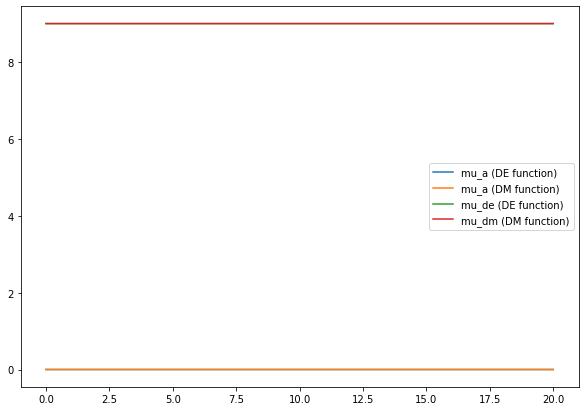

In [19]:
%matplotlib inline
# generate test mas
test_mas = np.linspace(0, 20, int(1e4))
# plot
plt.figure(figsize = (10, 7))
# mu_a for the DE and DM functions
plt.plot(test_mas, sigmoid(test_mas, a_a_de, b_a_de, c_a_de, d_a_de), alpha=1, label = 'mu_a (DE function)')
plt.plot(test_mas, sigmoid(test_mas, a_a_de, b_a_de, c_a_de, d_a_de), alpha=1, label = 'mu_a (DM function)')
# mu_de/mu-dm for the DE and DM functions
plt.plot(test_mas, sigmoid(test_mas, a_de, b_de, c_de, d_de), alpha = 1, label = 'mu_de (DE function)')
plt.plot(test_mas, sigmoid(test_mas, a_dm, b_dm, c_dm, d_dm), alpha = 1, label = 'mu_dm (DM function)')
# legend
plt.legend()

Plot how the variances `sigma_a`, `sigma_de` and `sigma_dm` for the $3$-D DE and DM functions evolve with $m_a$, respectively:

They should shrink (for the DE plot) or grow (for the DM plot) exponentially along the $a$-axis and be constant along the DE/DM axis.

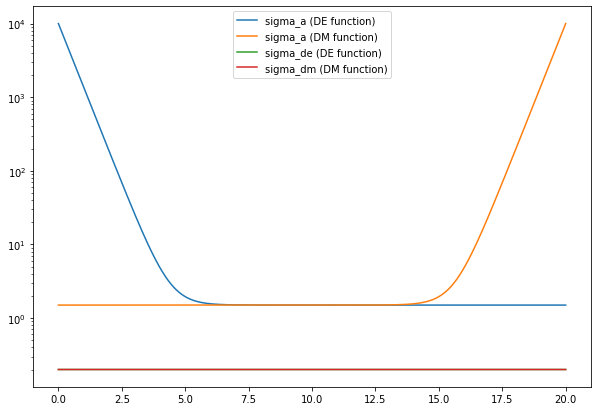

In [20]:
# plot
plt.figure(figsize = (10, 7))
# sigma_a for the DE and DM functions
plt.plot(test_mas, neg_exponential(test_mas, a_sa_de, b_sa_de, c_sa_de, d_sa_de), alpha=1, label = 'sigma_a (DE function)')
plt.plot(test_mas, neg_exponential(test_mas, a_sa_dm, b_sa_dm, c_sa_dm, d_sa_dm), alpha=1, label = 'sigma_a (DM function)')
# sigma_de/sigma_dm for the DE and DM functions
plt.plot(test_mas, neg_exponential(test_mas, a_sde, b_sde, c_sde, d_sde), alpha = 1, label = 'sigma_de (DE function)')
plt.plot(test_mas, neg_exponential(test_mas, a_sdm, b_sdm, c_sdm, d_sdm), alpha = 1, label = 'sigma_dm (DM function)')
# legend
plt.yscale('log')
plt.legend()

Plot how the rotation angles `theta_de` and `theta_dm` for the $3$-D DE and DM functions evolve with $m_a$, respectively:

For the DE plot, it should sigmoidally go from -$\frac{\pi}{4}$ to $0$ for $0 < m_a < 10$ and be constant at $0$ for $10 < m_a < 20$.

For the DM plot, it should be constant at $0$ for $0 < m_a < 10$ and sigmoidally go from $0$ to -$\frac{\pi}{4}$ for $10 < m_a < 20$.

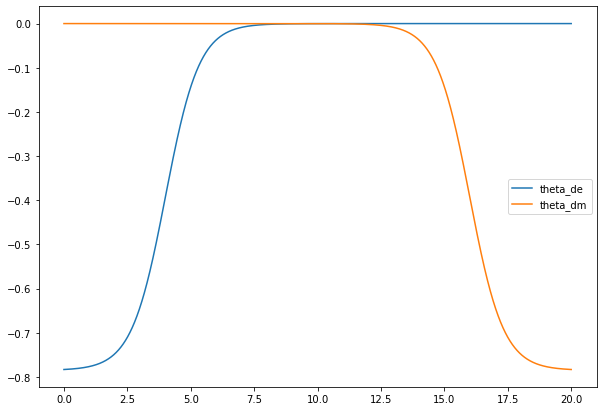

In [21]:
# plot
plt.figure(figsize = (10, 7))
# theta_de
plt.plot(test_mas, sigmoid(test_mas, a_theta_de, b_theta_de, c_theta_de, d_theta_de), alpha=1, label = 'theta_de')
# theta_dm
plt.plot(test_mas, sigmoid(test_mas, a_theta_dm, b_theta_dm, c_theta_dm, d_theta_dm), alpha=1, label = 'theta_dm')
# legend
plt.legend()

Compute the function over some $4$-D hypercube:

In [22]:
from multiprocessing import Pool

npoints = 100  # number of points in each dimension

# bounds of our sampling
x_lower, x_upper = 0, 10  # omega_a
y_lower, y_upper = 0, 10  # omega_de
z_lower, z_upper = 0, 10  # omega_dm
w_lower, w_upper = 0, 20  # m_a

X, Y, Z = np.meshgrid(np.linspace(x_lower, x_upper, npoints), np.linspace(y_lower, y_upper, npoints), 
                      np.linspace(z_lower, z_upper, npoints))

# slice of 4D space with m_a fixed at 0
# sliced_array = np.array((X.ravel(), Y.ravel(), Z.ravel(), np.zeros(X.size).ravel())).T

loglike_arr = np.zeros((npoints, npoints, npoints, npoints))  # create the array to store the log likelihoods

for l, m_a in tqdm(enumerate(np.linspace(w_lower, w_upper, npoints))):
    # iterate through m_a, taking slices for each fixed value of m_a
    # sliced_array[:,-1] = np.linspace(w_lower, w_upper, npoints)[l]
    # get_inv_cov uses de parameters if m_a < 10, otherwise use the dm parameters for the inverse covariance
    inv_cov = get_inv_cov(m_a=m_a)
    # now compute log likelihood for each element in the sliced array
    # multiprocessing, putting in omega_a, omega_de, omega_dm, m_a (now pulled out of the loop) and the inverse covariance
    with Pool() as pool:
        loglike_arr_slice = pool.starmap(log_likelihood, [(X[i, j, k], Y[i, j, k], Z[i, j, k], m_a, inv_cov) 
                                                      for i in range(0, len(X)) 
                                                      for j in range(0, len(Y)) 
                                                      for k in range(0, len(Z))])
    # turn loglike_arr_slice into an array and store it
    loglike_arr[l] = np.array(loglike_arr_slice).reshape(npoints, npoints, npoints)
    

100it [28:12, 16.92s/it]


In [ ]:
# OLD CODE

# from multiprocessing import Pool

# npoints = 100

# # bounds of our sampling
# x_lower, x_upper = 0, 10  # omega_a
# y_lower, y_upper = 0, 10  # omega_de
# z_lower, z_upper = 0, 10  # omega_dm
# w_lower, w_upper = 0, 20  # m_a

# X, Y, Z, W = np.meshgrid(np.linspace(x_lower, x_upper, npoints), np.linspace(y_lower, y_upper, npoints), 
#                       np.linspace(z_lower, z_upper, npoints), np.linspace(w_lower, w_upper, npoints))

# # multiprocessing to speed this up:
# with Pool() as pool:
#     loglike_arr = pool.starmap(log_likelihood, tqdm([(X[i, j, k, l], Y[i, j, k, l], Z[i, j, k, l], W[i, j, k, l])
#                                                  for i in range(0, len(X)) 
#                                                  for j in range(0, len(Y)) 
#                                                  for k in range(0, len(Z)) 
#                                                  for l in range(0, len(W))]))

# # make loglike_arr into an array with the proper shape
# loglike_arr = np.array(loglike_arr).reshape(100, 100, 100, 100)

Plotting:

In [ ]:
%matplotlib notebook
%matplotlib notebook

import matplotlib.pyplot as plt  
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

# ws
ws = np.linspace(w_lower, w_upper, npoints)
# hold omega_dm constant, vary m_a
omega_dm = 90  # index of the omega_dm
# zs
zs = np.linspace(z_lower, z_upper, npoints)

fig, ax = plt.subplots(1, 1, figsize = (12, 8))

def animate(w_ind, omega_dm_ind=omega_dm):
    ax.clear()
    arr = loglike_arr[:, :, omega_dm_ind, w_ind]  # hold omega_dm constant
    # min and max for the contours
    contour_min = np.min(arr)
    contour_max = np.max(arr)
    
    # plot
    
    ax.contourf(X[:, :, 0, 0], Y[:, :, 0, 0], arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
    # cb = plt.colorbar()
    # cb.set_ticks(np.linspace(contour_min, contour_max, 20), update_ticks=True)
    
    ax2 = ax.contour(X[:, :, 0, 0], Y[:, :, 0, 0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
    ax.clabel(ax2, inline=True, fontsize=10)
    # fig2 = plt.contour(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
    # plt.clabel(fig2, inline=True, fontsize=10)
    ax.set_xlabel(r'$\Omega_{a}$'), ax.set_ylabel(r'$\Omega_{DE}$') # x is omega_a, y is omega_de, z is m_a
    #    plt.tight_layout()
    ax.set_title(fr'$m_a = ${np.round(ws[w_ind], 2)}, $\Omega_DM = ${zs[omega_dm]}') # x is omega_a, y is omega_de, z is m_a
    
# plt.contourf(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
# cb = plt.colorbar()
# cb.set_ticks(np.linspace(contour_min, contour_max, 20), update_ticks=True)

# fig = plt.contour(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
# plt.clabel(fig, inline=True, fontsize=10)
# plt.xlabel('X'), plt.ylabel('Y')
# plt.tight_layout()
    
ani = FuncAnimation(fig, animate, frames=len(Z), interval=200, repeat=False)

# Save the animation as an animated GIF
ani.save("4d_u_function_plot_alternate.gif", dpi=500, writer=PillowWriter(fps=10))
# plt.close()

In [ ]:
%matplotlib notebook
%matplotlib notebook

from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

# zs
ws = np.linspace(w_lower, w_upper, npoints)
# hold omega_de constant, vary m_a
omega_de = 90
# ys (omega_de s)
ys = np.linspace(y_lower, y_upper, npoints)

fig, ax = plt.subplots(1, 1, figsize = (12, 8))

def animate(w_ind, omega_de_ind=omega_de):
    ax.clear()
    arr = loglike_arr[:, omega_de_ind, :, w_ind]  # hold omega_de constant her einstead
    # min and max for the contours
    contour_min = np.min(arr)
    contour_max = np.max(arr)
    
    # plot
    
    ax.contourf(X[:, :, 0, 0], Z[0, 0, :, :], arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
    # cb = plt.colorbar()
    # cb.set_ticks(np.linspace(contour_min, contour_max, 20), update_ticks=True)
    
    ax2 = ax.contour(X[:, :, 0, 0], Z[0, 0, :, :], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
    ax.clabel(ax2, inline=True, fontsize=10)
    # fig2 = plt.contour(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
    # plt.clabel(fig2, inline=True, fontsize=10)
    ax.set_xlabel(r'$\Omega_{a}$'), ax.set_ylabel(r'$\Omega_{DM}$') # x is omega_a, y is omega_de, z is m_a
    #    plt.tight_layout()
    ax.set_title(fr'$m_a = ${np.round(ws[w_ind], 2)}, $\Omega_DE = ${ys[omega_de]}') # x is omega_a, y is omega_de, z is m_a
    
# plt.contourf(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, npoints), cmap='viridis')
# cb = plt.colorbar()
# cb.set_ticks(np.linspace(contour_min, contour_max, 20), update_ticks=True)

# fig = plt.contour(X[:, :,0], Y[:, :,0], arr, levels = np.linspace(contour_min, contour_max, 10), colors='r')
# plt.clabel(fig, inline=True, fontsize=10)
# plt.xlabel('X'), plt.ylabel('Y')
# plt.tight_layout()
    
ani = FuncAnimation(fig, animate, frames=len(Z), interval=200, repeat=False)

# Save the animation as an animated GIF
ani.save("4d_u_function_plot_de_alternate.gif", dpi=500, writer=PillowWriter(fps=10))
# plt.close()

Now integrate over $\Omega_{DE}$ from $0$ to $10$ ($-\infty$ to $\infty$ should be the same...) and then $\Omega_{DM}$ from $0$ to $10$:

In [10]:
import scipy
# x is omega_a, y is omega_de, z is omega_dm, w is m_a

# multiprocessing to speed this up:

def f(omega_de, omega_dm, omega_a, m_a):
    return log_likelihood(omega_a, omega_de, omega_dm, m_a)

with Pool() as pool:
    integrated_likelihood = pool.starmap(scipy.integrate.dblquad, tqdm([(f, 0, 10, 0, 10, [X[0, i, 0, j], W[i, 0, 0, j]]) 
                                                                   for i in range(0, len(X)) 
                                                                   for j in range(0, len(W))]))
    
# make integrated likelihood into an array with the proper shape
integrated_likelihood = np.array(integrated_likelihood)[:,0].reshape(100, 100)

100%|██████████| 10000/10000 [07:15<00:00, 22.98it/s] 


And plot it to see if it matches the u-plot:

<IPython.core.display.Javascript object>


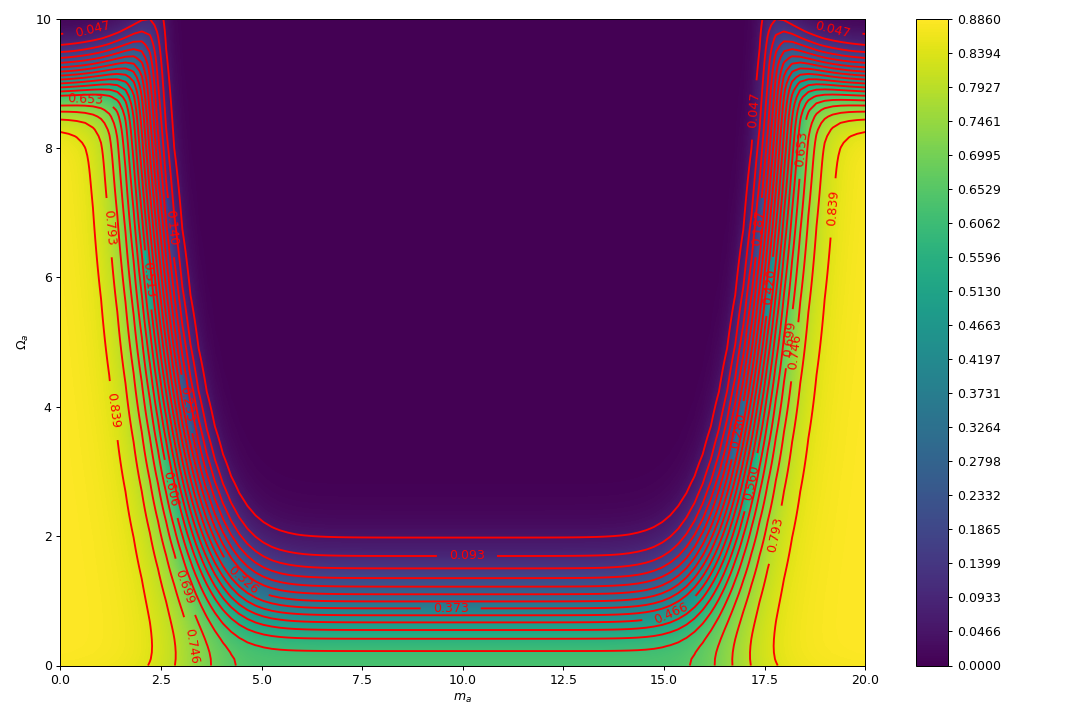

In [11]:
npoints = 500

# min and max for the contours
contour_min = np.min(integrated_likelihood)
contour_max = np.max(integrated_likelihood)

integrated_omega_a, integrated_m_a = X[0, :, 0, :], W[:, 0, 0, :] # these need to be formatted in the right way

# plot
plt.figure(figsize = (12, 8))
plt.contourf(integrated_m_a, integrated_omega_a, integrated_likelihood, levels=np.linspace(contour_min, contour_max, npoints), cmap='viridis')
cb = plt.colorbar()
# cb.formatter = LogFormatterExponent(base=10)
# this goes from ~ -50 to 0
cb.set_ticks(np.linspace(contour_min, contour_max, 20), update_ticks=True)

plt.xlabel(r'$m_a$'), plt.ylabel(r'$\Omega_a$')

# CONTOURS
fig = plt.contour(integrated_m_a, integrated_omega_a, integrated_likelihood, levels=np.linspace(contour_min, contour_max, 20), colors='r')
plt.clabel(fig, inline=True, fontsize=10)
plt.tight_layout()

# save
plt.savefig('integrated_4d_u_function.png', fmt='png')